In [121]:
!{sys.executable} -m pip install -v "opencv-python==4.5.1.48"
!{sys.executable} -m pip install matplotlib

Using pip 21.1.2 from d:\projects\put\computer-vision-project-2\venv\lib\site-packages\pip (python 3.7)
Non-user install because user site-packages disabled
Created temporary directory: C:\Users\aszcz\AppData\Local\Temp\pip-ephem-wheel-cache-8gcj481e
Created temporary directory: C:\Users\aszcz\AppData\Local\Temp\pip-req-tracker-mpf_hxw4
Initialized build tracking at C:\Users\aszcz\AppData\Local\Temp\pip-req-tracker-mpf_hxw4
Created build tracker: C:\Users\aszcz\AppData\Local\Temp\pip-req-tracker-mpf_hxw4
Entered build tracker: C:\Users\aszcz\AppData\Local\Temp\pip-req-tracker-mpf_hxw4
Created temporary directory: C:\Users\aszcz\AppData\Local\Temp\pip-install-xczghlcb
Created temporary directory: C:\Users\aszcz\AppData\Local\Temp\pip-unpack-ruzbuom_
Removed build tracker: 'C:\\Users\\aszcz\\AppData\\Local\\Temp\\pip-req-tracker-mpf_hxw4'


In [122]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt


Load image

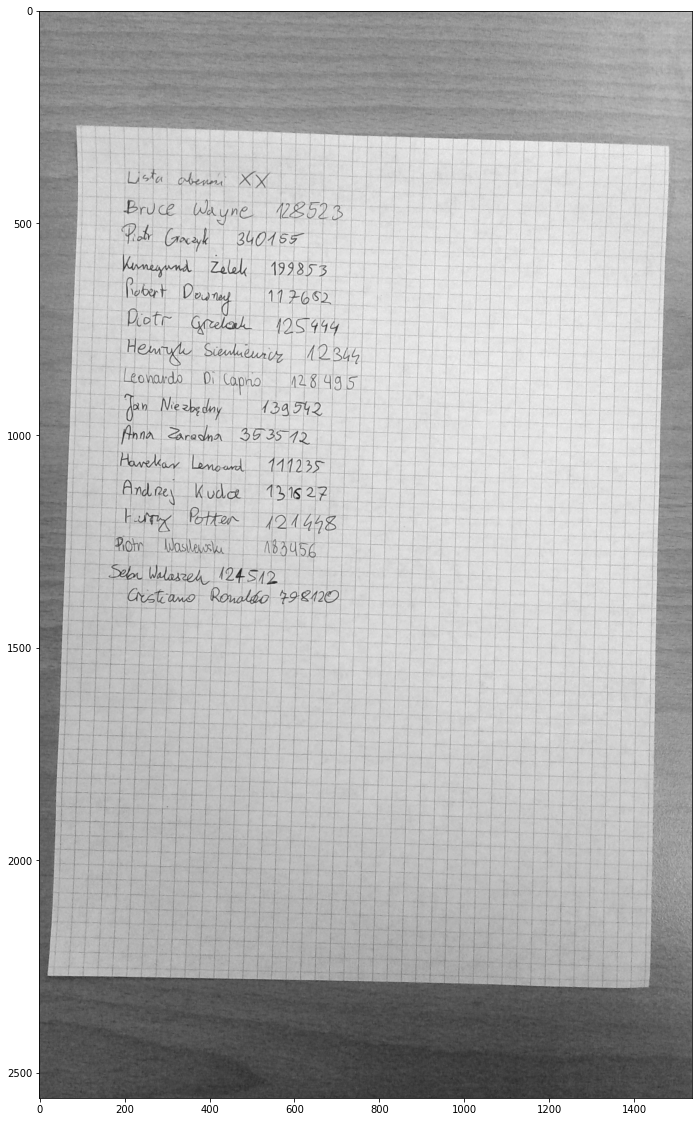

In [123]:
image_orig = cv.imread('../data/img_3.jpg', cv.IMREAD_GRAYSCALE)

plt.figure(figsize=(20, 20))
plt.imshow(image_orig, cmap='gray')
plt.show()

Denoise image for better contour detection

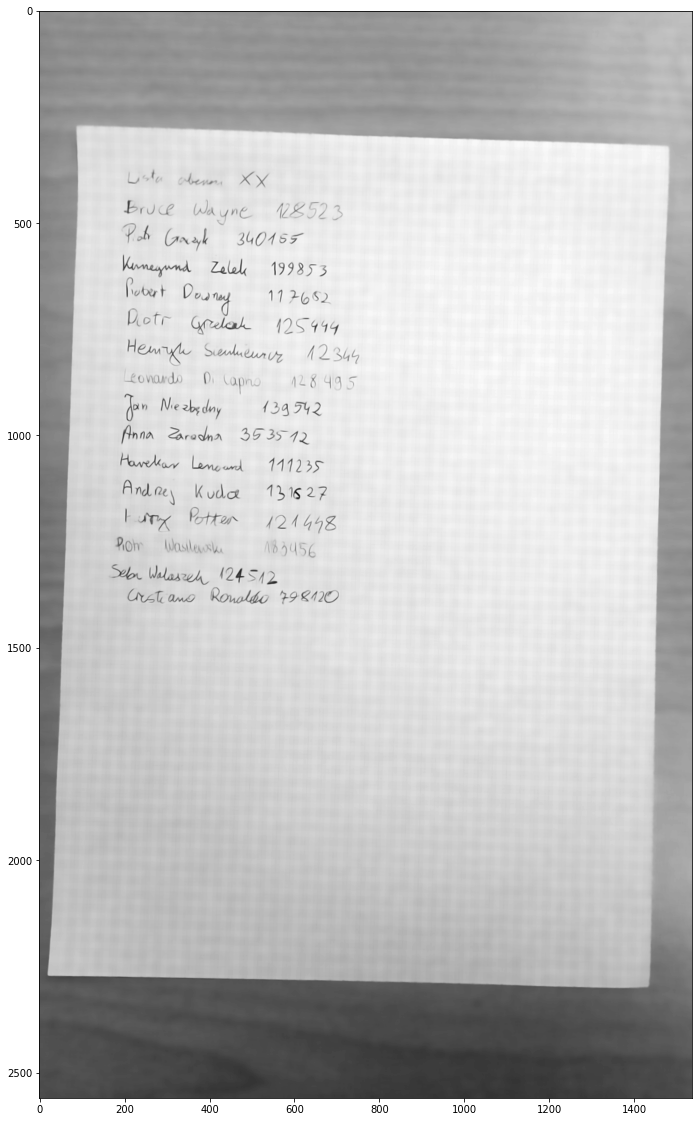

In [124]:
# https://docs.opencv.org/master/d1/d79/group__photo__denoise.html#ga4c6b0031f56ea3f98f768881279ffe93
image = cv.fastNlMeansDenoising(image_orig, None, 20, 7, 21)

plt.figure(figsize=(20, 20))
plt.imshow(image, cmap='gray')
plt.show()

Threshold image

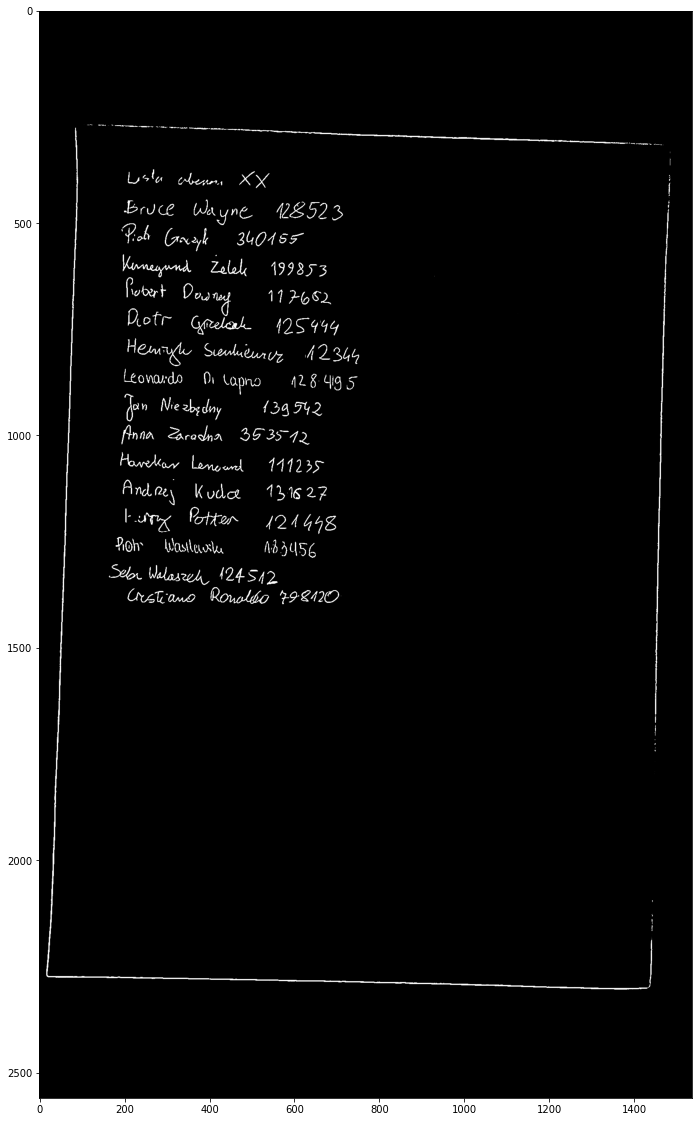

In [125]:
thresh = cv.adaptiveThreshold(src=image,
                              maxValue=255,
                              adaptiveMethod=cv.ADAPTIVE_THRESH_GAUSSIAN_C,
                              thresholdType=cv.THRESH_BINARY_INV,
                              blockSize=11,
                              C=3)
thresh = cv.fastNlMeansDenoising(thresh, None, 30, 7, 21)

plt.figure(figsize=(20, 20))
plt.imshow(thresh, cmap='gray')
plt.show()

Detect page contour

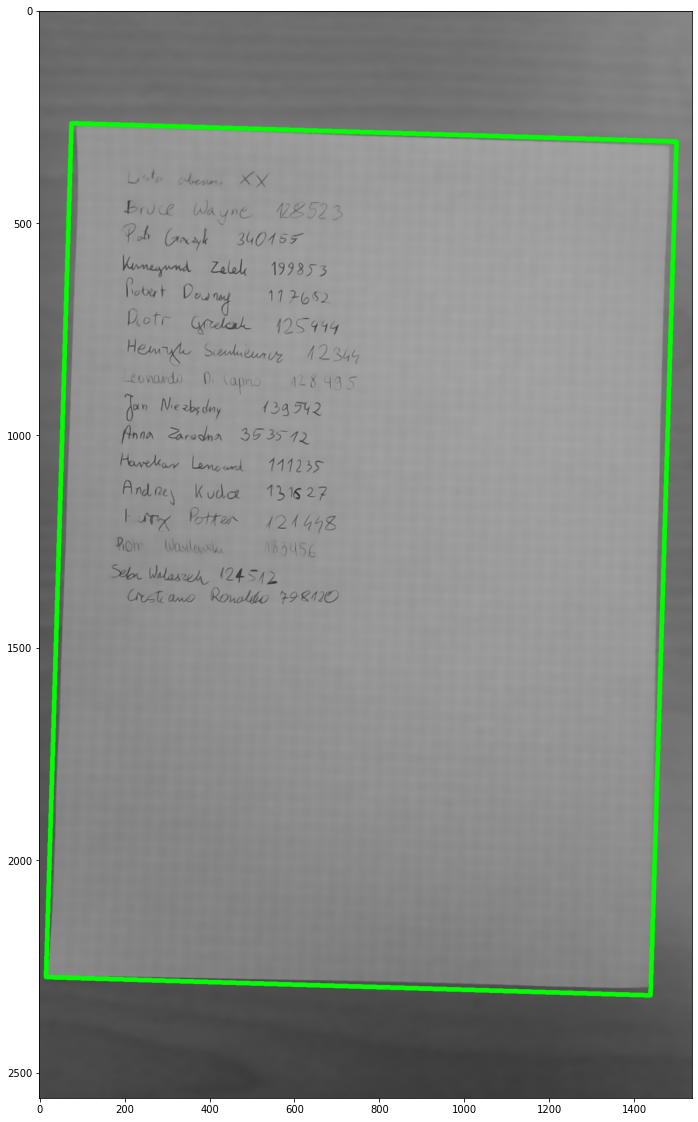

In [126]:
contours_, _ = cv.findContours(thresh, cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)

img_copy = cv.cvtColor(image, cv.COLOR_GRAY2BGR)

contours_flat = np.vstack(contours_).squeeze()

colors = [
    (255, 0, 0),
    (0, 255, 0),
    (0, 255, 0),
    (255, 255, 0),
    (0, 255, 255),
    (255, 0, 255)
]

rect = cv.minAreaRect(contours_flat)
box = cv.boxPoints(rect)
cv.drawContours(img_copy, [np.int0(box)], -1, colors[1], 10)

plt.figure(figsize=(20, 20))
plt.imshow(img_copy)
plt.show()


Cut page from image

Based on https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/

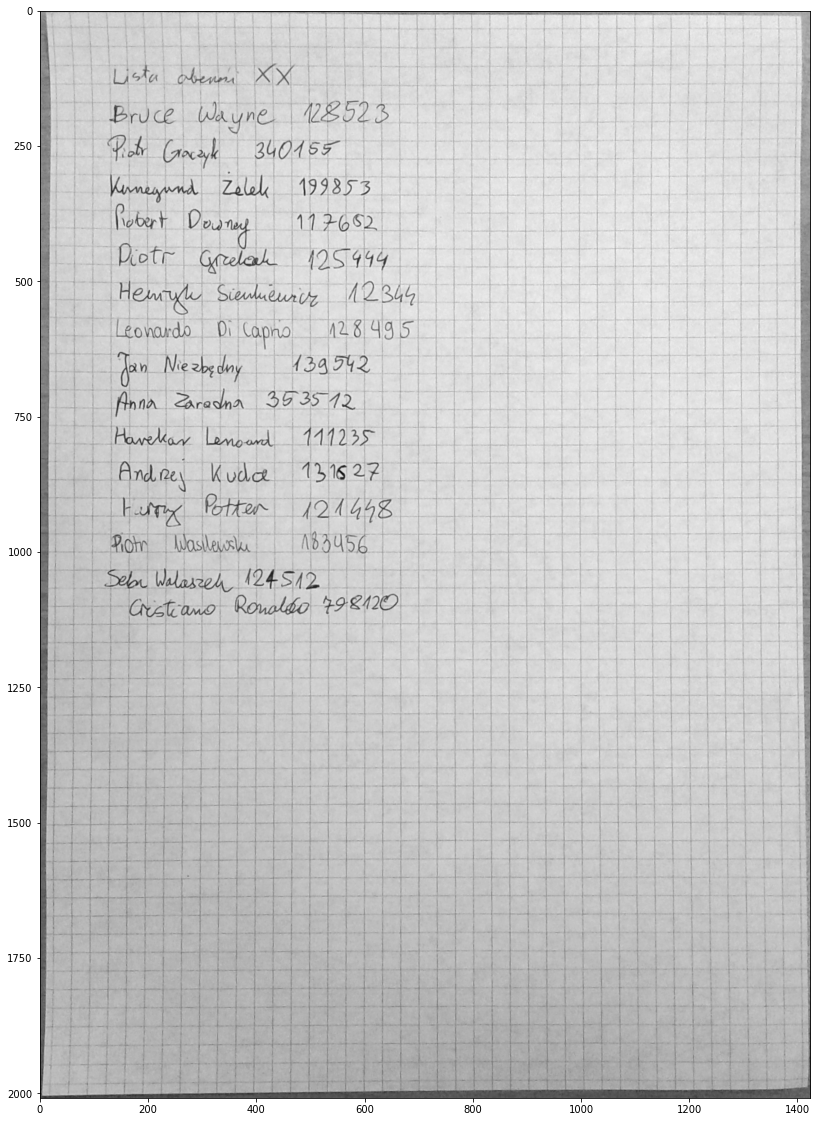

In [127]:
def order_points(pts_):
    rect_ = np.zeros((4, 2), dtype="float32")
    s = pts_.sum(axis=1)
    rect_[0] = pts_[np.argmin(s)]
    rect_[2] = pts_[np.argmax(s)]
    diff = np.diff(pts_, axis=1)
    rect_[1] = pts_[np.argmin(diff)]
    rect_[3] = pts_[np.argmax(diff)]
    return rect_


def four_point_transform(image_, rect_):
    (tl, tr, br, bl) = tuple(rect_)

    width_a = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    width_b = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    max_width = max(int(width_a), int(width_b))

    height_a = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    height_b = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    max_height = max(int(height_a), int(height_b))

    dst = np.array([
        [0, 0],
        [max_width - 1, 0],
        [max_width - 1, max_height - 1],
        [0, max_height - 1]], dtype="float32")

    moments = cv.getPerspectiveTransform(rect_, dst)
    warped = cv.warpPerspective(image_, moments, (max_width, max_height))
    return warped


box_ordered = order_points(box)

img_warped = four_point_transform(image_orig, box_ordered)

plt.figure(figsize=(20, 20))
plt.imshow(img_warped, cmap='gray')
plt.show()


Save result image

In [128]:
cv.imwrite("straightened.png", img_warped)

True